In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import numpy as np
import tensorflow as tf
from object_loc_helper import get_simple_model_V2, iou, PlotLosses, IOU_loss, get_concat_model, plot_batch, get_VGG16
from custom_losses import custom_loss, classes_acc, confidence_acc, bounding_box_mse, iou_v2, custom_loss_IOU, cat_cross_entropy_loss, bin_cross_entropy_loss, boundind_box_mse_loss, IOU_loss_V2

Intersection Over Union Paper
https://arxiv.org/pdf/1608.01471.pdf

In [39]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from object_loc_helper import get_class_names_map, PlotLosses, PlotLossesV2

In [40]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'
reduced_dataset_folder = 'dataset_5_classes_plus_world/'

In [41]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [42]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [43]:
from  keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
class GeneratorMultipleOutputsV2(Sequence):
    def __init__(self, annotations_dict, folder, batch_size, flip = 'no_flip', concat_output=True, featurewise_center=True, get_filenames = False):
        # flip = {no_flip, always, random}
        self.concat_output = concat_output
        self.flip = flip
        self.get_filenames = get_filenames
        np.random.seed(seed=40)
        self.annotations_dict = annotations_dict
        datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
        self.generator = datagen.flow_from_directory(
            directory=folder,
            target_size=(375, 500),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=42
        )
    def get_image_object_center(self):
        bboxes = []
        batch_index = self.generator.batch_index
        if self.generator.batch_index == 0:
            batch_index = self.__len__()
        batch_filenames = np.array(self.generator.filenames)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        annot_dicts = []
        box_widths = []
        box_heights = []
        centerXs = []
        centerYs = []
        object_detected_arr = []
        for filename in batch_filenames:
            arr = filename.split('/')
            class_id = arr[0]
            image_idx = arr[1].split('.')[0]
            if class_id == 'world':
                annot_dict = {'width':-1, 'height':-1, 'bounding_boxes':[[0,0,0,0]]}
                object_detected_arr.append(0)
            else:
                annot_dict = self.annotations_dict[class_id][image_idx]
                object_detected_arr.append(1)
                
            img_width = annot_dict['width']
            img_height = annot_dict['height']
            
            bounding_box = annot_dict['bounding_boxes'][0]
            box_width = (bounding_box[2]-bounding_box[0])
            box_height = (bounding_box[3]-bounding_box[1])
            centerX = (bounding_box[0]+(box_width)/2)/img_width
            centerY = (bounding_box[1]+(box_height)/2)/img_height
            box_widths.append(box_width/img_width)
            box_heights.append(box_height/img_height)
            centerXs.append(centerX)
            centerYs.append(centerY)
            annot_dicts.append(annot_dict)
        return np.array(centerXs), np.array(centerYs), np.array(box_widths), np.array(box_heights), batch_filenames, annot_dicts, np.array([object_detected_arr])
    def __len__(self):
        return int(np.ceil(self.generator.samples / float(self.generator.batch_size)))
    def __getitem__(self, idx):
        data = next(self.generator)
        centerX, centerY, width, height, batch_filenames, annot_dicts, object_detected_arr = self.get_image_object_center()
        if self.flip == 'random':
            inices_to_flip = np.random.randint(0, 2, data[0].shape[0]).nonzero()
            data[0][inices_to_flip] = np.flip(data[0][inices_to_flip], axis = 2)
            centerX[inices_to_flip] = 1 - centerX[inices_to_flip]
        elif self.flip == 'always':
            data[0][:] = np.flip(data[0][:], axis = 2)
            centerX = 1 - centerX
        if 'world' in self.generator.class_indices:
            classes_array = np.delete(data[1], [self.generator.class_indices['world']], axis=1)
        else:
            classes_array = data[1]
        
        centerX = centerX*(object_detected_arr).reshape(-1)
        centerY = centerY*(object_detected_arr).reshape(-1)
        width = width*(object_detected_arr).reshape(-1)
        height = height*(object_detected_arr).reshape(-1)
        
        if self.concat_output:
            output = np.hstack([classes_array, np.array([centerX, centerY, width, height]).T, object_detected_arr.T])
        else:
            output = [classes_array, np.array([centerX, centerY, width, height]).T, object_detected_arr.T]
        if self.get_filenames:
            return (data[0], output, batch_filenames, annot_dicts, object_detected_arr)
        else:    
            return (data[0], output)
    def __next__(self):
        return self.__getitem__(0)
    def __iter__(self):
        return self

In [44]:
val_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_val, val_folder, 100, flip = 'random', get_filenames=True, 
                                                            concat_output=True)
#train_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_train, train_folder, 64, flip = 'random', concat_output=True)

Found 259 images belonging to 6 classes.


[0.         1.         0.         0.         0.         0.498
 0.53466667 0.988      0.92533333 1.        ]


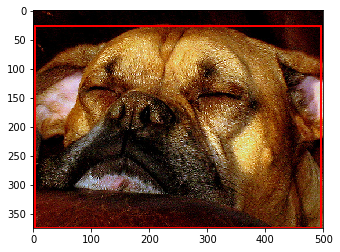

[1.         0.         0.         0.         0.         0.568
 0.576      0.856      0.50666667 1.        ]


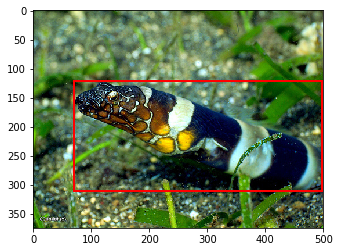

[1.         0.         0.         0.         0.         0.321
 0.49866667 0.562      0.93333333 1.        ]


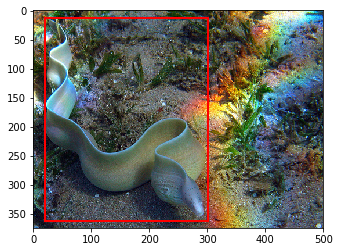

[0.         1.         0.         0.         0.         0.455
 0.45733333 0.622      0.74933333 1.        ]


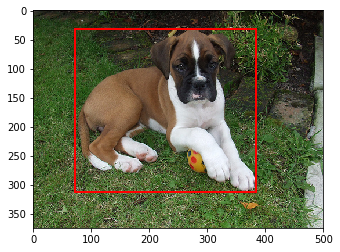

[0.         0.         0.         1.         0.         0.589
 0.55744125 0.794      0.83289817 1.        ]


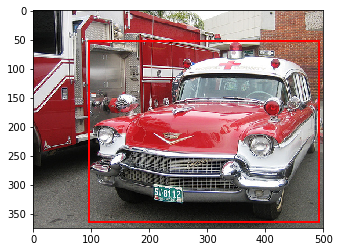

[0.         0.         1.         0.         0.         0.443
 0.61066667 0.278      0.43733333 1.        ]


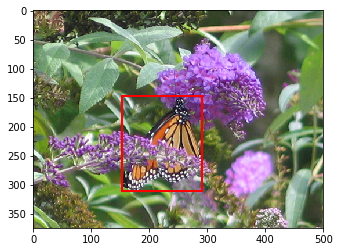

[0.         0.         0.         0.         1.         0.505
 0.33733333 0.666      0.50933333 1.        ]


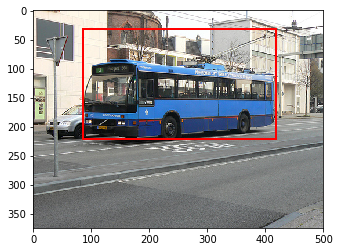

[ 0.  0.  0.  0.  0.  0. -0. -0. -0.  0.]


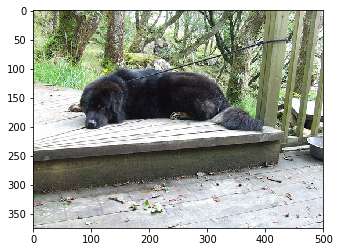

[0.         0.         1.         0.         0.         0.481
 0.508      0.518      0.30133333 1.        ]


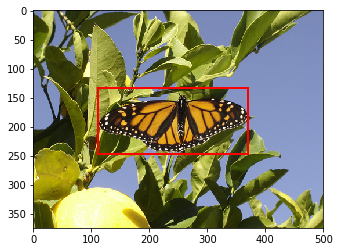

[ 0.  0.  0.  0.  0. -0. -0. -0. -0.  0.]


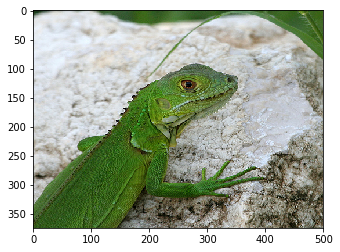

In [45]:
plot_batch(val_generator_multiple_outputs, count = 10)

In [62]:
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D, Flatten, Dense, Dropout
from keras.constraints import max_norm
from keras import Model
def get_VGG16_V2(n_classes = 5, input_shape=(375, 500, 3), dropout_rate_1 = 0.5, dropout_rate_2 = 0.5, dropout_rate_3 = 0.5, N_trainable = 19):
    modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    GAP = GlobalAveragePooling2D()(modelVGG16.output)
    classification = Dense(n_classes, activation='softmax', name='category_output', kernel_constraint=max_norm(1.))(Dropout(dropout_rate_1)(GAP))
    bounding_box = Dense(4, name='bounding_box', kernel_constraint=max_norm(2.))(Dropout(dropout_rate_2)(GAP))
    confidence = Dense(1, activation='sigmoid', name='obj_confidence', kernel_constraint=max_norm(2.))(Dropout(dropout_rate_3)(GAP))
    all_outs = Concatenate(name='concatenated_outputs')([classification, bounding_box, confidence])
    model = Model(inputs=modelVGG16.input, outputs=[all_outs])
    for layer in model.layers[N_trainable:]:
        layer.trainable = True
    for layer in model.layers[:N_trainable]:
        layer.trainable = False
    return model

In [63]:
n_classes=5
#model = get_simple_model(input_shape=(375, 500, 3), n_classes=n_classes, dropout_rate_1=0.1, dropout_rate_2=0.05)
#model = get_VGG16_concat(n_classes=n_classes, dropout_rate_1=0.5, dropout_rate_2=0.25, N_trainable=17)
model = get_VGG16_V2(N_trainable=17)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 375, 500, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 375, 500, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 187, 250, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [64]:
y_true = np.array([[1, 0, 0, 0, 0, 0.5, 0.5, 0.5, 0.5, 1],
                   [0, 0, 0, 0, 0, 0.5, 0.25, 0.5, 0.5, 0.2],
                   [0, 1, 0, 0, 0, 0.5, 0.25, 0.5, 0.5, 1]], dtype='float32')
y_pred = np.array([[0.5, 0.5, 0.1, 0, 0, 0.4, 0.5, 0.5, 0.5, 0.8],
                   [0, 0, 0, 0, 0, 0.5, 0.25, 0.5, 0.5, 0.2],
                   [0, 1, 0, 0, 0, 0.5, 0.25, 0.5, 0.5, 1]], dtype='float32')

In [65]:
from keras import backend as K
y_pred = K.constant(y_pred, dtype='float32')
y_true = K.constant(y_true, dtype='float32')

In [66]:
with tf.Session() as sess:
    print(custom_loss(y_true, y_pred).eval(session=sess))

0.6366608


In [67]:
# losses = {"concatenated_outputs": custom_loss_IOU}
losses = {"concatenated_outputs": custom_loss_IOU}
lossWeights = {"concatenated_outputs": 1.0}
metrics = {"concatenated_outputs": [classes_acc, confidence_acc, bounding_box_mse, iou_v2, cat_cross_entropy_loss]}

In [68]:
train_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_train, train_folder, 32, flip = 'random', concat_output=True)
val_generator_multiple_outputs = GeneratorMultipleOutputsV2(annotations_dict_val, val_folder, 33, flip = 'random', concat_output=True)

Found 4457 images belonging to 6 classes.
Found 259 images belonging to 6 classes.


In [69]:
259%33

28

In [73]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=losses,
              #optimizer=rmsprop(),
              optimizer=Adam(lr=0.0001),
              metrics=metrics,
              loss_weights = lossWeights)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


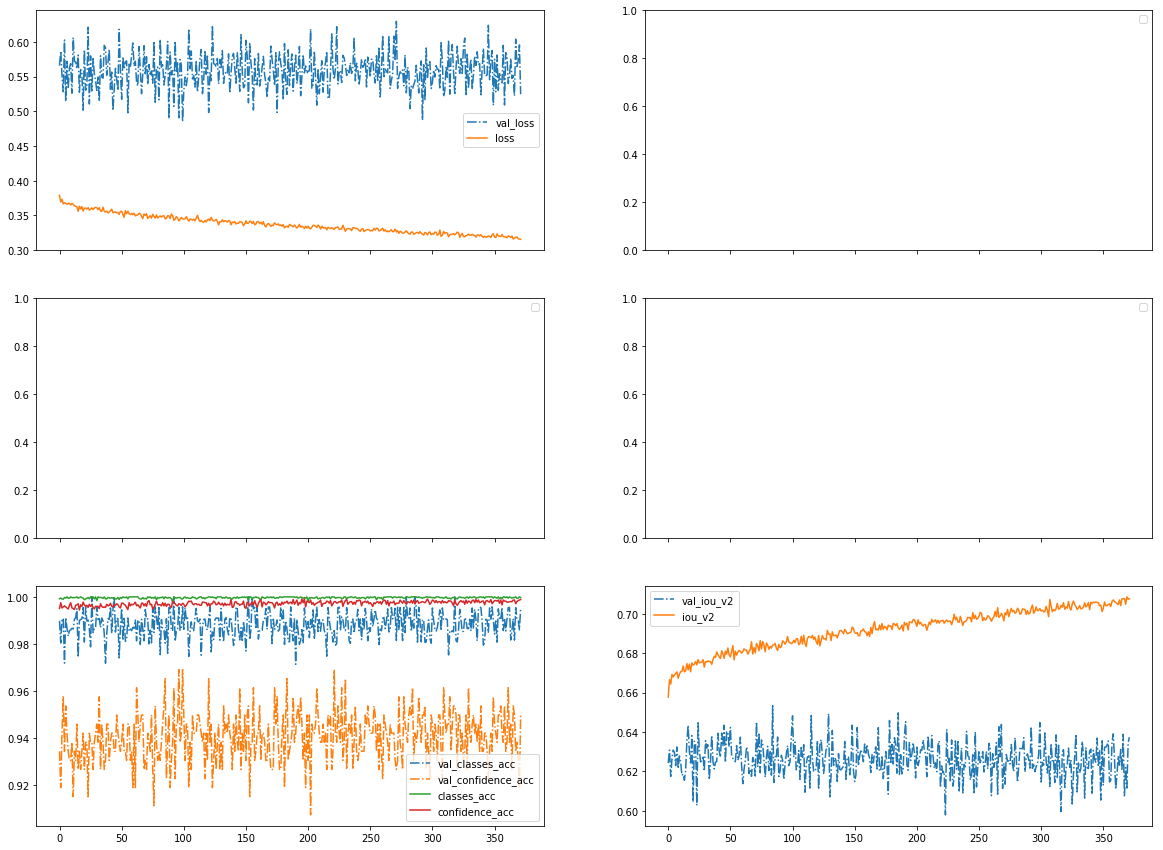

Epoch 373/2000
 99/140 [====================>.........] - ETA: 12s - loss: 0.3221 - classes_acc: 0.9995 - confidence_acc: 0.9978 - bounding_box_mse: 0.0077 - iou_v2: 0.7043 - cat_cross_entropy_loss: 0.0066

KeyboardInterrupt: 

In [74]:
plot_losses = PlotLossesV2(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=2000,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [ ]:
model.evaluate_generator(val_generator_multiple_outputs)

In [ ]:
model.evaluate_generator(train_generator_multiple_outputs)

In [ ]:
model.save_weights(filename+'_last.hdf5')

In [72]:
#model.load_weights('5_classes_world.hdf5')
model.load_weights('runtime_best-002.hdf5')

In [ ]:
model.evaluate_generator(val_generator_multiple_outputs)